In [1]:
# Basic Template
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from skimage.measure import compare_psnr
import cnnbin
from cnnbin.utils import psnr
from cnnbin.utils import clipto8bit




### Color image
example of training on one image the whole view at once. Note; in this example only the image itself is used to train the network.

In [2]:
sigma = 50
image_ref =imageio.imread('data/monarch.bmp')
image = image_ref+sigma * np.random.standard_normal(image_ref.shape)

binned_ref = np.mean(cnnbin.split_diagonal_rgb(image_ref),0)
binned_mean = np.mean(cnnbin.split_diagonal_rgb(image),0)

print(f'Image of shape {image.shape}')

Image of shape (512, 768, 3)


In [3]:
net = cnnbin.CNNbin(multichannel = True,depth=4, start_filts=48)
size = net.summary()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 128, 128]           1,344
         MaxPool2d-2           [-1, 48, 64, 64]               0
          DownConv-3  [[-1, 48, 64, 64], [-1, 48, 128, 128]]               0
            Conv2d-4           [-1, 48, 64, 64]          20,784
         MaxPool2d-5           [-1, 48, 32, 32]               0
          DownConv-6  [[-1, 48, 32, 32], [-1, 48, 64, 64]]               0
            Conv2d-7           [-1, 48, 32, 32]          20,784
         MaxPool2d-8           [-1, 48, 16, 16]               0
          DownConv-9  [[-1, 48, 16, 16], [-1, 48, 32, 32]]               0
           Conv2d-10           [-1, 48, 16, 16]          20,784
         DownConv-11  [[-1, 48, 16, 16], [-1, 48, 16, 16]]               0
  ConvTranspose2d-12           [-1, 48, 32, 32]           9,264
           Conv2d-13           [-1, 96, 32, 32]          

PSNR (36.5/22.1): 100%|█████| 10/10 [00:02<00:00,  6.02it/s]


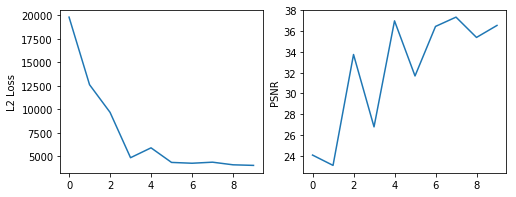

PSNR (34.1/22.1): 100%|███| 200/200 [00:22<00:00,  9.18it/s]


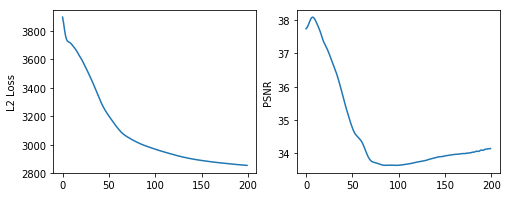

PSNR (34.3/22.1): 100%|███| 200/200 [00:22<00:00,  8.87it/s]


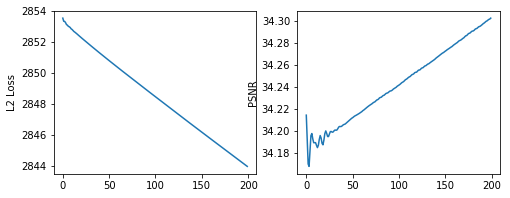

In [4]:
net.train_image(image,num_epochs= 10, learning_rate=1e-3,alpha = 0.99)
net.plot_train()
net.train_image(image,num_epochs= 200, learning_rate=1e-4,alpha = 0.99)
net.plot_train()
net.train_image(image,num_epochs= 200, learning_rate=1e-5,alpha = 0.99)
net.plot_train()



###  Train on random subsamples

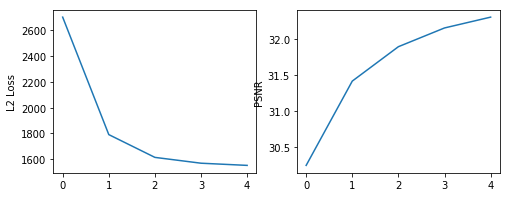

In [5]:
net.train_random(image,num_epochs= 5,num_batches = 10,learning_rate=1e-3,alpha = 0.99)
net.plot_train()


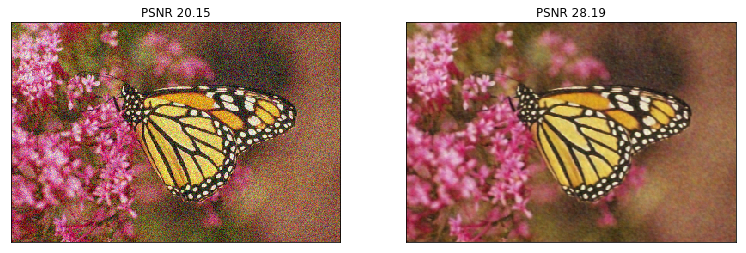

In [6]:
image_filter = clipto8bit(net.filter_patch(image))
plt.figure(figsize=(13,5))
for i,im in enumerate([binned_mean,image_filter]):
    plt.subplot(1,2,1+i)    
    plt.imshow(np.clip(im/255.0,0,1))
    plt.title(f'PSNR {psnr(binned_ref,im,255):.2f}')
    plt.xticks([])
    plt.yticks([])
plt.savefig(f'images/monarch_compare',bbox_inches='tight')


### Batch
Network can also be trained on a list of images
Filtered image has to have sizes%2==0  but patch based training can be done on odd-shaped images aswell.

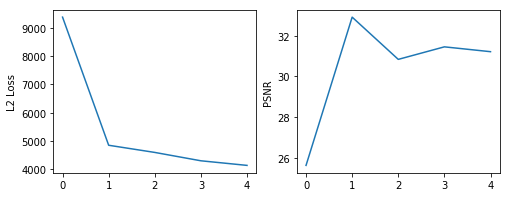

In [8]:
sigma = 80
images_ref =[
    imageio.imread(x) for x in ['data/barbara.bmp','data/monarch.bmp','data/comic.bmp']
]
images = [x + sigma * np.random.standard_normal(x.shape) for x in images_ref]

block_size = (128,128)
net = cnnbin.CNNbin(multichannel = True, depth=4, start_filts=48, block_size = block_size)
net.train_list(images,num_epochs= 5,samples = 5, lr=1e-3,alpha = 0.99)
net.plot_train()

### Patches
Large images can be trained by either random subpatches or deterministic splitting into fusable subimages. Fusing is done by weighted averaging after applying a window funtion.


In [18]:
block_size = (128,128)
net = cnnbin.CNNbin(multichannel = True, depth=4, start_filts=48, block_size = block_size, batch_size=4)


In [55]:
image = imageio.imread('data/comic.bmp')[:-1,:,:] 
image = image_ref+sigma * np.random.standard_normal(image_ref.shape)
binned_mean = np.mean(cnnbin.split_diagonal_rgb(image),0)
print(image.shape)

(512, 768, 3)


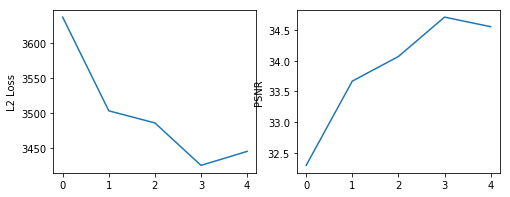

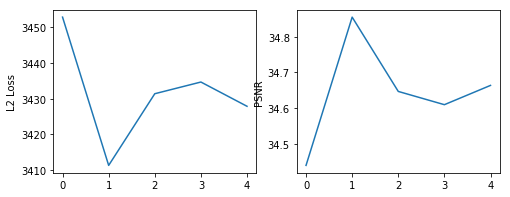

In [56]:
block_size = (512,512)
net.train_random(image,num_epochs= 5,samples = 100,learning_rate=1e-3,alpha = 0.99)
net.plot_train()
net.train_random(image,num_epochs= 5,samples = 100,learning_rate=1e-4,alpha = 0.99)
net.plot_train()

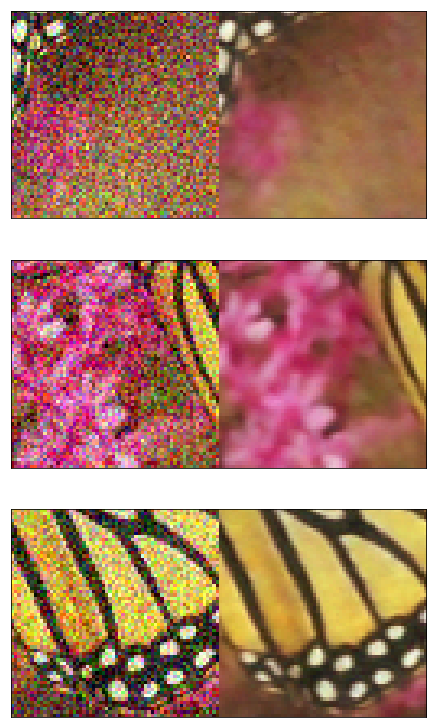

In [58]:
from cnnbin.utils import random_patches
image_filter = net.filter(image,sampling=1.1)

block_size = (64,64)
n_patches = 3
seed = 3421
ref = random_patches(binned_mean, block_size, n_patches, seed)
filtered_random = random_patches(image_filter, block_size, n_patches, seed)
W = 13
plt.figure(figsize=(W,n_patches*W/3))
for i in range(n_patches):
    plt.subplot(n_patches,1,1+i)    
    plt.imshow(np.concatenate((clipto8bit(ref[i]),clipto8bit(filtered_random[i]),),1))
    plt.xticks([])
    plt.yticks([])
    
    